# Classification problem with a bit more input dimensions

Original copied from: https://github.com/KindXiaoming/pykan/blob/master/tutorials/Example_3_classfication.ipynb \
EfficientKAN by Blealtan: https://github.com/Blealtan/efficient-kan 

Test with MNIST dataset (slightly deeper network)

In [1]:
# from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import torch
import numpy as np

import struct
from array import array
from os.path  import join

from tqdm import tqdm


import os
import sys

In [2]:
# sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', 'efficient-kan-master', 'src', 'efficient_kan')))
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', 'efficient-kan-master', 'src')))

from efficient_kan import KAN 

In [3]:
print('Has CUDA:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('device name:', torch.cuda.get_device_name(0))

Has CUDA: True
device name: NVIDIA GeForce RTX 3060


### Prepare the dataset

##### Read from file

In [4]:
# MNIST Data Loader Class
# https://www.kaggle.com/code/hojjatk/read-mnist-dataset
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

In [5]:
# Set file paths based on added MNIST Datasets
input_path = 'MNIST_dataset'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

In [6]:
# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_tr, y_tr), (x_te, y_te) = mnist_dataloader.load_data()

##### Data processing

In [7]:
x_train = torch.tensor(np.array(x_tr))
y_train = torch.tensor(np.array(y_tr))
x_test  = torch.tensor(np.array(x_te))
y_test  = torch.tensor(np.array(y_te))

In [8]:
x_train.shape

torch.Size([60000, 28, 28])

In [9]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
x_test  = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2]))

In [10]:
# chop off a ratio of the train sets
ratio_keep = 0.5

num_train = x_train.shape[0]
num_test = x_test.shape[0]

num_train_1 = int(num_train * ratio_keep)
num_test_1  = int(num_test * ratio_keep)

x_train = x_train[:num_train_1, :]
y_train = y_train[:num_train_1]

x_test = x_test[:num_test_1, :]
y_test = y_test[:num_test_1]

In [11]:
# convert to one hot (not needed with torch.nn.CrossEntropyLoss)
# y_train = torch.nn.functional.one_hot(y_train.to(torch.int64))
# y_test  = torch.nn.functional.one_hot(y_test.to(torch.int64))

In [12]:
# normalie the dataset
vmax = x_train.amax()
x_train = x_train / vmax
x_test = x_test / vmax

In [13]:
dataset = {}

dataset['train_input'] = x_train.to(device='cuda')
dataset['test_input']  = x_test.to(device='cuda')
dataset['train_label'] = y_train.to(device='cuda')
dataset['test_label']  = y_test.to(device='cuda')

X = dataset['train_input']
y = dataset['train_label']

In [14]:
in_dim = x_train.shape[1]
in_dim

784

### Create and train model

In [15]:
# create a KAN model on CUDA GPU
model = KAN([in_dim, 100, 10], grid_size=3, spline_order=3).to(device='cuda')

In [16]:
# see total number of params
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Total params:', pytorch_total_params)
print('Trainable params:', pytorch_total_params_trainable)

Total params: 635200
Trainable params: 635200


##### utility funcs

In [17]:
def train_acc():
    outp = model(dataset['train_input'])
    return torch.mean((torch.argmax(outp, dim=1) == dataset['train_label']).float())

def test_acc():
    outp = model(dataset['test_input'])
    return torch.mean((torch.argmax(outp, dim=1)  == dataset['test_label'] ).float())

In [18]:
# batch size
batch_size = int(num_train / 60)
# batch_size = -1

# def train(steps, lr, batch_size=batch_size):
#     # train it on CUDA GPU
#     results = model.train(dataset, opt="Adam", steps=steps, metrics=(train_acc, test_acc), loss_fn=loss_fn, lr=lr, batch=batch_size, device='cuda')
#     print('train acc:', results['train_acc'][-1])
#     print('test acc:', results['test_acc'][-1])
#     return results

In [19]:
def train(model, num_epochs, loss_fn, dataset, optimizer):
    res = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
    for n in tqdm(range(num_epochs)):
        y_pred = model(dataset['train_input'])
        loss = loss_fn(y_pred, dataset['train_label'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        test_loss = loss_fn(model.forward(dataset['test_input']), dataset['test_label'])
        
        res['train_loss'].append(torch.sqrt(loss).cpu().detach().numpy())
        res['test_loss'].append(torch.sqrt(test_loss).cpu().detach().numpy())
        
        res['train_acc'].append(train_acc().cpu().detach().numpy())
        res['test_acc'].append(test_acc().cpu().detach().numpy())
    return res

In [20]:
def plot(results):
    fig, [ax_loss, ax_acc] = plt.subplots(figsize=(14, 6), nrows=1, ncols=2)
    steps = range(1, len(results['train_loss']) + 1)
    
    # plot training and test loss
    ax_loss.plot(steps, results['train_loss'], label='Training Loss')
    ax_loss.plot(steps, results['test_loss'], label='Validation Loss')
    ax_loss.title.set_text('Training and Validation Loss')
    ax_loss.set_xlabel('Steps')
    ax_loss.set_ylabel('Loss')

    # plot training and test accuracy
    ax_acc.plot(steps, results['train_acc'], label='Training Accuracy')
    ax_acc.plot(steps, results['test_acc'], label='Validation Accuracy')
    ax_acc.title.set_text('Training and Validation Accuracy')
    ax_acc.set_xlabel('Steps')
    ax_acc.set_ylabel('Accuracy')
    
    plt.show()

##### training in action!

In [21]:
# use categorical cross entropy loss
loss_fn = torch.nn.CrossEntropyLoss()

# learning rate and adam optimizer
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

results = train(model, 300, loss_fn, dataset, optimizer)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:42<00:00,  2.93it/s]


### Results and Metrics

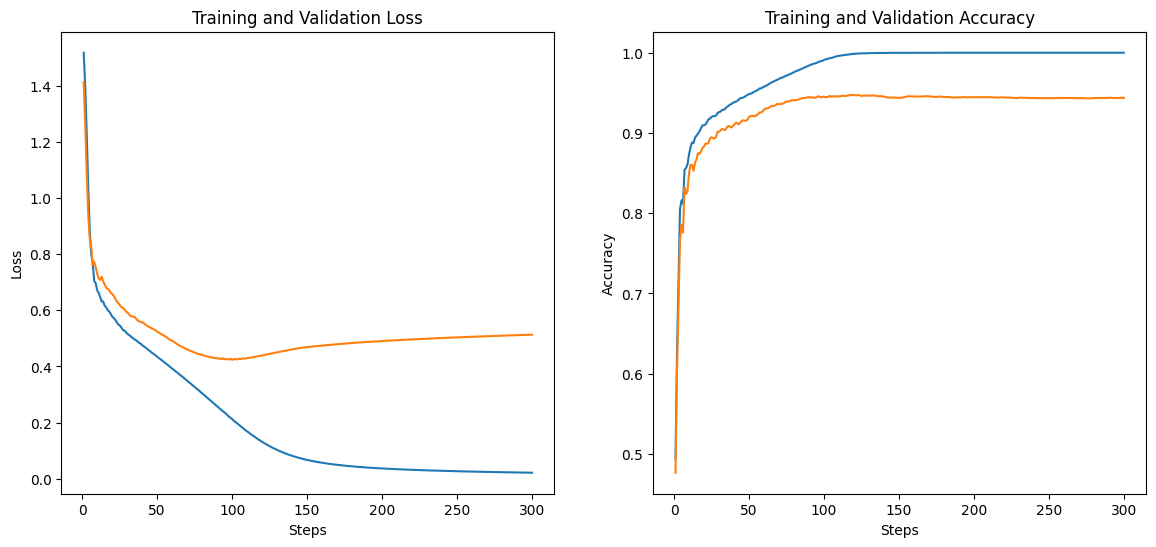

In [22]:
plot(results)

In [23]:
print('Highest train accuracy', np.amax(results['train_acc']), ', at epoch:', np.argmax(results['train_acc']))
print('Highest test accuracy', np.amax(results['test_acc']), ', at epoch:', np.argmax(results['test_acc']))

Highest train accuracy 1.0 , at epoch: 179
Highest test accuracy 0.9474 , at epoch: 117


In [24]:
# get array of test data output and create a confusion matrix
test_outp = torch.argmax(model(dataset['test_input']), dim=1).cpu()
test_labl = dataset['test_label'].cpu()

[]

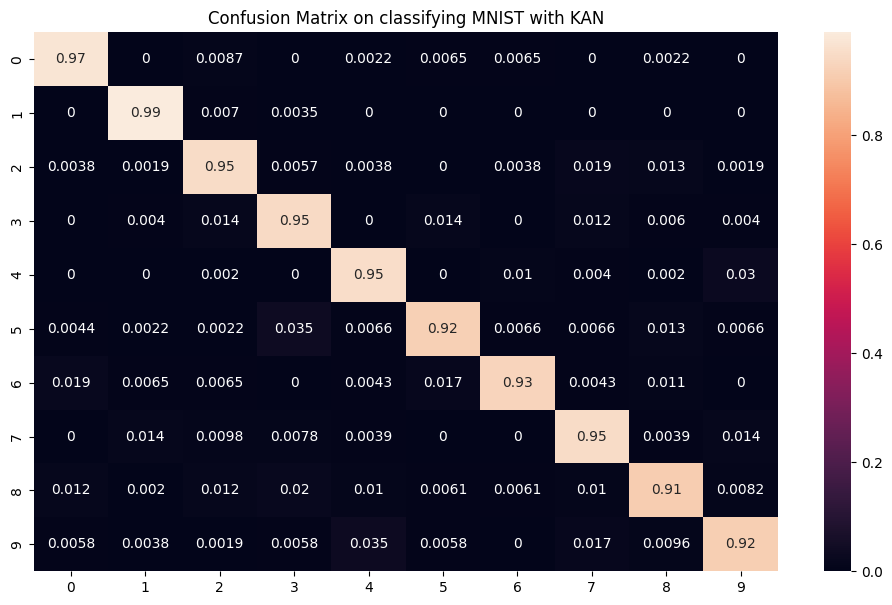

In [25]:
cf_matrix = confusion_matrix(test_labl, test_outp)
# the class labels '0' to '9'
class_labels = [str(i) for i in range(10)]

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in class_labels],
                     columns = [i for i in class_labels])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix on classifying MNIST with KAN')
plt.plot()

In [26]:
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

In [27]:
tsne_2d = TSNE(n_components=2).fit_transform(dataset['test_input'].cpu())

E:\random projects\virtual_envs\pykan_venv_2\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\random projects\virtual_envs\pykan_venv_2\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [28]:
# get the boolean map of correct vs. incorrect classification
correct_items = test_labl == test_outp
incorrect_items = ~correct_items

In [29]:
tsne_2d[:, 0][correct_items].shape

(4719,)

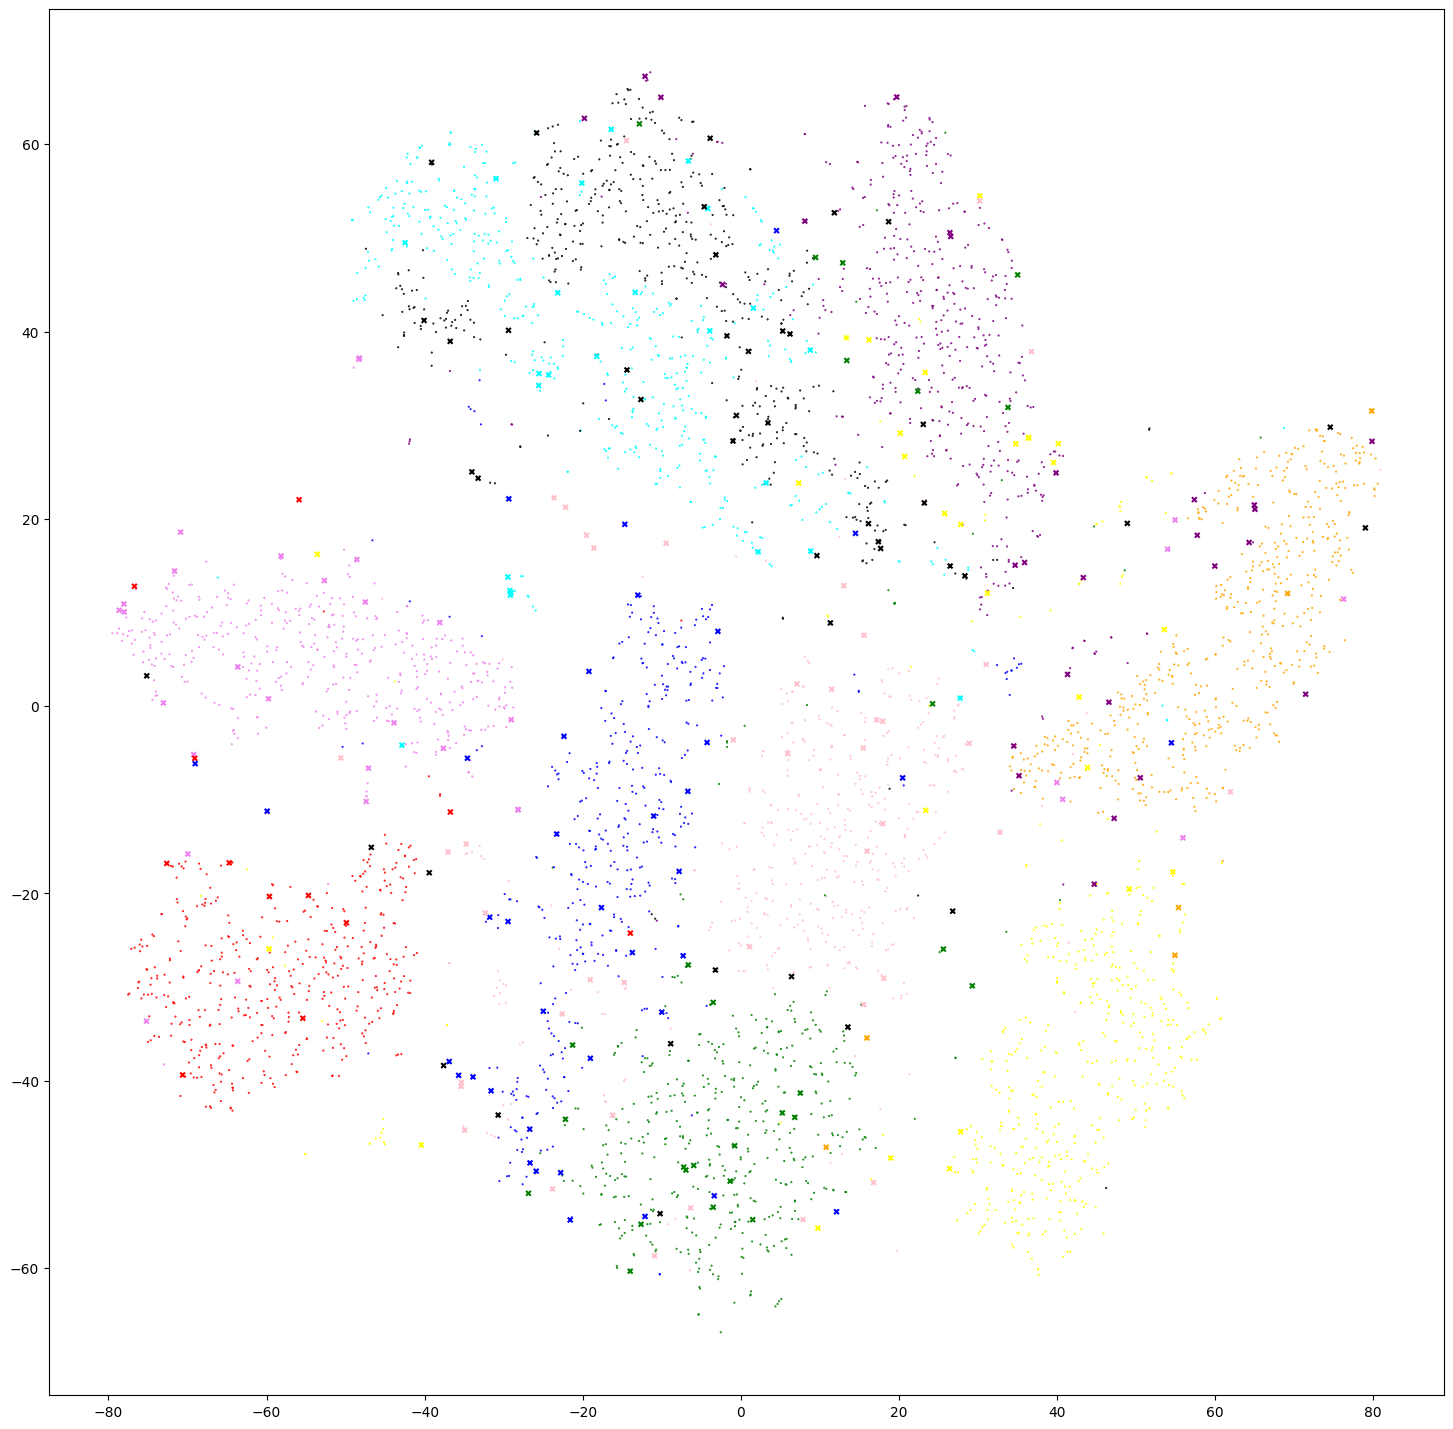

In [30]:
colors = ['red','orange','yellow','green','cyan','blue','violet','purple','pink','black']

fig = plt.figure(figsize=(18,18))

# plot correct and incorrect results with different markers
plt.scatter(tsne_2d[:, 0][correct_items], tsne_2d[:, 1][correct_items], s=1, c=test_labl[correct_items], cmap=ListedColormap(colors), marker='.')
plt.scatter(tsne_2d[:, 0][incorrect_items], tsne_2d[:, 1][incorrect_items], s=12, c=test_labl[incorrect_items], cmap=ListedColormap(colors), marker='x')